In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import division, print_function
from builtins import reversed
from builtins import map, zip
from collections import MutableSequence, Sequence
import copy
from math import ceil
from numbers import Complex, Integral, Real
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from numpy import linalg as LA
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [99]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 17.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [100]:
import yfinance
test_set = yfinance.download(['FB', 'AOS', 'ABT', 'GOOGL'], start="2020-01-01", end = "2021-12-31")
test_set['Close'].to_csv("./drive/MyDrive/Data/raw_data.csv")
returns = test_set['Close'].pct_change(periods=1).dropna()
returns.to_csv("./drive/MyDrive/Data/returns.csv")

[*********************100%***********************]  4 of 4 completed


In [ ]:
test_set['Close'].shape

(504, 4)

In [ ]:
returns.shape

(503, 4)

In [3]:
returns = pd.read_csv("./drive/MyDrive/Data/returns.csv", index_col = "Date")

In [101]:
returns.head()

,ABT,AOS,FB,GOOGL
Date,,,,
2020-01-03,-0.012191,-0.008792,-0.005291,-0.005231
2020-01-06,0.005239,0.006336,0.018834,0.026654
2020-01-07,-0.005559,-0.006716,0.002164,-0.001932
2020-01-08,0.004076,-0.001479,0.010138,0.007118
2020-01-09,0.002668,-0.004443,0.014311,0.010498


La librería toma como input **los retornos diarios**. Hay una diferencia pequeña en la matriz de correlacioń muestral estimada, como puede verse en el resultado de la celda de arriba (correlación obtenida con numpy sobre los retornos) y la celda de abajo (correlación obtenida después de estandarizar los retornos con respecto a su varianza y obtener después la matriz de correlación con scikit learn)

In [5]:
X = StandardScaler(with_mean=False,
                           with_std=True).fit_transform(returns)
ec = EmpiricalCovariance(store_precision=False,
                             assume_centered=True)
ec.fit(X)
E = ec.covariance_
print(E)

[[1.00340483 0.36876917 0.42016156]
 [0.36876917 1.00429765 0.3233594 ]
 [0.42016156 0.3233594  1.0027847 ]]


Si se estandarizan primero los retornos con respecto a su desviación estándar y se estima la mat corr con numpy, se obtiene lo siguiente

In [6]:
np.corrcoef(X.T)

array([[1.        , 0.36494389, 0.41708236],
       [0.36494389, 1.        , 0.31989997],
       [0.41708236, 0.31989997, 1.        ]])

Revisando ahora el resultado realizando la normalizaición de forma manual, notándo que la normalización que se está llevando a cabo en el paquete es dividir la columna entre su desviación estándar, cuando lo que se indica en el paper es que se debe utilizar la volatilidad seccional para cada día. 

In [ ]:
np.std(returns)

ABT    0.019856
AOS    0.020923
FB     0.024288
dtype: float64

In [ ]:
returns.std()

ABT    0.019876
AOS    0.020944
FB     0.024313
dtype: float64

In [ ]:
returns / np.std(returns)

,ABT,AOS,FB
Date,,,
2020-01-03,-0.613973,-0.420210,-0.217852
2020-01-06,0.263864,0.302814,0.775417
2020-01-07,-0.279988,-0.320965,0.089082
2020-01-08,0.205300,-0.070689,0.417402
2020-01-09,0.134366,-0.212371,0.589210
...,...,...,...
2021-12-23,0.061599,0.685276,0.596801
2021-12-27,0.832392,1.114436,1.343579
2021-12-28,-0.352466,0.473989,0.004758


In [ ]:
X

array([[-0.61397259, -0.42021047, -0.21785166],
       [ 0.26386431,  0.30281436,  0.77541671],
       [-0.27998775, -0.32096481,  0.08908165],
       ...,
       [-0.35246632,  0.47398949,  0.00475831],
       [ 0.25814477,  0.15085506, -0.39005268],
       [-0.06777491, -0.28962325,  0.17047736]])

A continuación se lleva a cabo la estandarización tal cual se sugiere por Bun

In [102]:
# Se quita la media muestral de cada activo 
returns_wth_mean = returns - returns.mean()
# Primero se obtiene el cuadrado de los retornos
retornos_squared = returns_wth_mean**2
suma_ret_sq = retornos_squared.sum(axis = 1)
cross_sectional_volatility = np.sqrt(suma_ret_sq)
cross_sectional_volatility.head()

Date
2020-01-03    0.019313
2020-01-06    0.031165
2020-01-07    0.011163
2020-01-08    0.011147
2020-01-09    0.016822
dtype: float64

Comprobación manual del cálculo dd la cross sectional volatility

In [103]:
returns_wth_mean.head(3)

,ABT,AOS,FB,GOOGL
Date,,,,
2020-01-03,-0.013349,-0.010164,-0.006573,-0.006947
2020-01-06,0.004081,0.004964,0.017552,0.024938
2020-01-07,-0.006718,-0.008087,0.000882,-0.003648


In [104]:
np.sqrt((-0.013349)**2+(-0.010164)**2+(-0.006573)**2)

0.018019628908498644

Aplicación de la estandarización mediante la división de la cross sectional volatiliy para poder obtener $\tilde{r_{it}} := \frac{r_{it}}{\hat{\sigma_{it}}}$

In [105]:
standardized_returns = returns_wth_mean.divide(cross_sectional_volatility, axis = 0)
standardized_returns.head()

,ABT,AOS,FB,GOOGL
Date,,,,
2020-01-03,-0.691229,-0.526277,-0.340344,-0.359723
2020-01-06,0.130935,0.159286,0.563187,0.800190
2020-01-07,-0.601795,-0.724458,0.079004,-0.326745
2020-01-08,0.261756,-0.255739,0.794505,0.484606
2020-01-09,0.089724,-0.345687,0.774536,0.522057


Comprobación manual de la obtención de $\tilde{r}_{it}$

In [106]:
print(-0.013349 / 0.018020 ) 
print( 0.004081/ 0.018691)
print(-0.006718/0.010551)

-0.7407880133185349
0.21834037772189827
-0.6367168988721449


Se supone que esta primer transformación tiene por objetivo quitar estacionalidad de los retornos, por lo tanto se revisan a continuación como se ven los retornos originales

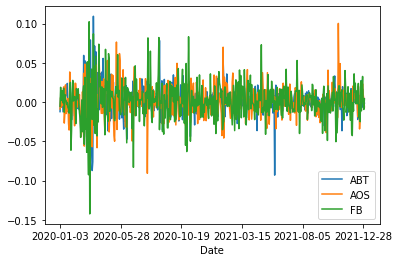

In [25]:
returns.plot()

In [107]:
dicky_fuller_returns = adfuller(returns['ABT'])
print('ADF Statistic: %f' % dicky_fuller_returns[0])
print('p-value: %f' % dicky_fuller_returns[1])
print('Critical Values:')
for key, value in dicky_fuller_returns[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.033275
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


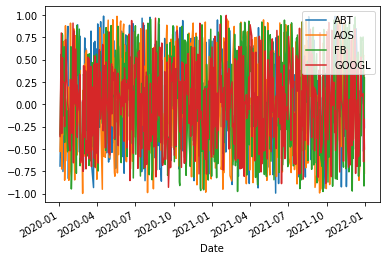

In [108]:
standardized_returns.plot()

In [30]:
dicky_fuller_returns = adfuller(standardized_returns['ABT'])
print('ADF Statistic: %f' % dicky_fuller_returns[0])
print('p-value: %f' % dicky_fuller_returns[1])
print('Critical Values:')
for key, value in dicky_fuller_returns[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -25.691888
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


Se puede observar en la gráfica que se quitan los "picos" y en efecto la serie se vuelve aún "menos estacionaria", pues según este estadístico, los retornos originales no tenían estacionariedad de entrada. El estadístico también se vuelve "más negativo", lo que confirma lo mismo que en la gráfica.

Por último , se divide $\tilde{r}$ entre $\sigma_i$ (que es la volatilidad de los retornos ya estandarizados, es decir, de $\tilde{r}$, entendida como la desviación estándar) para obtener la matriz $X:= \frac{\tilde{r}_{it}}{\sigma_i}$

In [109]:
final_X = standardized_returns /  standardized_returns.std()
final_X.head()

,ABT,AOS,FB,GOOGL
Date,,,,
2020-01-03,-1.473667,-1.012529,-0.613362,-0.798265
2020-01-06,0.279147,0.306458,1.014965,1.775709
2020-01-07,-1.282998,-1.393819,0.142380,-0.725083
2020-01-08,0.558052,-0.492028,1.431843,1.075394
2020-01-09,0.191288,-0.665083,1.395855,1.158502


In [32]:
final_X.shape

(503, 3)



---



A continuación se comprueba que la forma de calcular la matriz $E$ (ecuacioń 1) es la misma que la implementada en en numpy.corrcoef, solo que esta última añade algunas modificaciones para obtener unos exactos en la diagonal y disminuir errores de redondeo, que son lo que causa que haya variaciones entre las dos matrices de correlación estimadas. En cuanto a la expresión de la matriz de correlación muestral como suma de productos de matrices de eigenvalues y eigenvectors (ecuación 2), es posible observar que la aproximación no es exacta.

In [34]:
np.corrcoef(final_X.T)

array([[1.        , 0.090652  , 0.16021267],
       [0.090652  , 1.        , 0.1394979 ],
       [0.16021267, 0.1394979 , 1.        ]])

In [35]:
((final_X.T @ final_X)* (1/final_X.shape[0])).to_numpy()

array([[0.99913339, 0.09008402, 0.16065973],
       [0.09008402, 0.998146  , 0.13895586],
       [0.16065973, 0.13895586, 0.99853456]])

In [36]:
ei_vals, ei_vect = LA.eig(((final_X.T @ final_X)* (1/final_X.shape[0])).to_numpy())

In [37]:
mat_E_eigen = np.zeros((3, 3), dtype=float)
for i in range(len(ei_vect)):
  temp = ei_vals[i]*(np.atleast_2d(ei_vect[i]).T @ np.atleast_2d(ei_vect[i]))
  mat_E_eigen = mat_E_eigen + temp
mat_E_eigen

array([[0.99000629, 0.11947767, 0.14821828],
       [0.11947767, 1.04514467, 0.12309487],
       [0.14821828, 0.12309487, 0.96066298]])

In [38]:
ei_vals, ei_vect = LA.eig(np.corrcoef(final_X.T))

In [39]:
mat_E_eigen = np.zeros((3, 3), dtype=float)
for i in range(len(ei_vect)):
  temp = ei_vals[i]*(np.atleast_2d(ei_vect[i]).T @ np.atleast_2d(ei_vect[i]))
  mat_E_eigen = mat_E_eigen + temp
mat_E_eigen

array([[0.99091691, 0.11996484, 0.14762857],
       [0.11996484, 1.0472566 , 0.12358536],
       [0.14762857, 0.12358536, 0.96182648]])



---



In [40]:
def checkDesignMatrix(X):
    """
       Parameters
       ----------
       X: a matrix of shape (T, N), where T denotes the number
           of samples and N labels the number of features.
           If T < N, a warning is issued to the user, and the transpose
           of X is considered instead.
       Returns:
       T: type int
       N: type int
       transpose_flag: type bool
           Specify if the design matrix X should be transposed
           in view of having less rows than columns.       
    """
    
    try:
        assert isinstance(X, (np.ndarray, pd.DataFrame, pd.Series,
                              MutableSequence, Sequence))
    except AssertionError:
        raise
        sys.exit(1)

    # Código para convertir a X en un array, si es que no lo es  
    X = np.asarray(X, dtype=float)
    # Código para convertir a X en un array de numpy de dos dimensiones 
    X = np.atleast_2d(X)

    if X.shape[0] < X.shape[1]:
        warnings.warn("The Marcenko-Pastur distribution pertains to "
                      "the empirical covariance matrix of a random matrix X "
                      "of shape (T, N). It is assumed that the number of "
                      "samples T is assumed higher than the number of "
                      "features N. The transpose of the matrix X submitted "
                      "at input will be considered in the cleaning schemes "
                      "for the corresponding correlation matrix.", UserWarning)
        
        T, N = reversed(X.shape)
        transpose_flag = True
    else:
        T, N = X.shape
        transpose_flag = False
        
    return T, N, transpose_flag

In [143]:
def xiHelper(x, q, E):
    """Helper function to the rotationally-invariant, optimal shrinkage
       estimator of the true correlation matrix (implemented via function
       optimalShrinkage of the present module). 
       Parameters
       ----------
       x: type derived from numbers.Real
           Would typically be expected to be an eigenvalue from the
           spectrum of correlation matrix E. The present function
           can however handle an arbitrary floating-point number.
       q: type derived from numbers.Real
           The number parametrizing a Marcenko-Pastur spectrum.
       E: type numpy.ndarray
           Symmetric correlation matrix associated with the 
           Marcenko-Pastur parameter q specified above.
       Returns
       -------
       xi: type float
           Cleaned eigenvalue of the true correlation matrix C underlying
           the empirical correlation E (the latter being corrupted 
           with in-sample noise). This cleaned version is computed
           assuming no prior knowledge on the structure of the true
           eigenvectors (thereby leaving the eigenvectors of E unscathed). 
       References
       ----------
       * "Rotational invariant estimator for general noisy matrices",
         J. Bun, R. Allez, J.-P. Bouchaud and M. Potters
         arXiv: 1502.06736 [cond-mat.stat-mech]
       * "Cleaning large Correlation Matrices: tools from Random Matrix Theory",
         J. Bun, J.-P. Bouchaud and M. Potters
         arXiv: 1610.08104 [cond-mat.stat-mech]
    """

    try:
        assert isinstance(x, Real)
        assert isinstance(q, Real)
        assert isinstance(E, np.ndarray) and E.shape[0] == E.shape[1]
        assert np.allclose(E.transpose(1, 0), E)
    except AssertionError:
        raise
        sys.exit(1)

    N = E.shape[0]
    
    # esta z es z_k en el paper Box1 (ESTÁ BIEN)
    z = x - 1j / np.sqrt(N)
    
    # esta s_k es en realidad s_k(z_k) en el paper (ESTA DIFERENTE)
    s = stieltjes(z, E)
    
    #xi es \xi_l^{RIE} en el paper (ESTA IGUAL)
    xi = x / abs(1 - q + q * z * s)**2
    print("xi_rie")
    print(xi)

    return xi

In [42]:
def stieltjes(z, E):
    """
       Parameters
       ----------
       z: complex number
       E: square matrix
       Returns
       -------
       A complex number, the resolvent of square matrix E, 
       also known as its Stieltjes transform.
       Reference
       ---------
       "Financial Applications of Random Matrix Theory: a short review",
       J.-P. Bouchaud and M. Potters
       arXiv: 0910.1205 [q-fin.ST]
    """

    try:
        assert isinstance(z, Complex)
        
        assert isinstance(E, (np.ndarray, pd.DataFrame,
                              MutableSequence, Sequence))
        E = np.asarray(E, dtype=float)
        E = np.atleast_2d(E)
        assert E.shape[0] == E.shape[1]
    except AssertionError:
        raise
        sys.exit(1)

    N = E.shape[0]
    
    ret = z * np.eye(N, dtype=float) - E
    
   
    ret = np.trace(ret) / N
    print("el z_k")
    print(z)

    print("el s_k correspondiente")
    print(ret)

    return ret

In [141]:
def gammaHelper(x, q, N, lambda_N, inverse_wishart=False):
    """Helper function to optimalShrinkage function defined below.
       The eigenvalue to the cleaned estimator of a true correlation
       matrix are computed via the function xiHelper defined above in
       the module at hand. 
       
       It is known however that when N is not very large
       a systematic downward bias affects the xiHelper estimator for small
       eigenvalues of the noisy empirical correlation matrix. This bias
       can be heuristically corrected by computing
       xi_hat = xi_RIE * max(1, Gamma),
       with Gamma evaluated by the function gammaHelper herewith.
       Parameters
       ----------
       x: type float or any other type derived from numbers.Real
           Typically an eigenvalue from the spectrum of a sample
           estimate of the correlation matrix associated to some
           design matrix X. However, the present function supports
           any arbitrary floating-point number x at input.
       q: type derived from numbers.Real
           Parametrizes a Marcenko-Pastur spectrum.
       N: type derived from numbers.Integral
           Dimension of a correlation matrix whose debiased, 
           rotationally-invariant estimator is to be assessed via
           the function RIE (see below), of which the present function
           is a helper.
       lambda_N: type derived from numbers.Real
           Smallest eigenvalue from the spectrum of an empirical
           estimate to a correlation matrix.
        
       inverse_wishart: type bool default: False
            Wether to use inverse wishart regularization
       Returns
       ------
       Gamma: type float
           Upward correction factor for computing a debiased 
           rotationally-invariant estimator of a true underlying 
           correlation matrix. 
       Reference
       ---------
       "Cleaning large Correlation Matrices: tools from Random Matrix Theory",
        J. Bun, J.-P. Bouchaud and M. Potters
        arXiv: 1610.08104 [cond-mat.stat-mech]
    """

    try:
        assert isinstance(x, Real)
        assert isinstance(q, Real)
        assert isinstance(N, Integral)
        assert isinstance(lambda_N, Real)
    except AssertionError:
        raise
        sys.exit(1)

    z = x - 1j / np.sqrt(N)
    print("el q")
    print(q)
    print("el lambda N")
    print(lambda_N)
    # Este lambda plus está igual  que en el paper (ESTÁ BIEN)
    lambda_plus = (1 + np.sqrt(q))**2

    lambda_plus /= (1 - np.sqrt(q))**2

    lambda_plus *= lambda_N
    print("lambda _plus")
    print(lambda_plus)
    # Este sigma cuadrada está igual que en el N (ESTÁ BIEN)
    sigma_2 = lambda_N / (1 - np.sqrt(q))**2
    print("sigma_2")
    print(sigma_2)
    
    # gmp defined below stands for the Stieltjes transform of the
    # rescaled Marcenko-Pastur density, evaluated at z
    # esta función es la (18) y ESTÁ MALLLLL ( NOTAR QUE EN EL PAPER 
    # LA PARTE QUE SE RESTA ESTÁ COMO \SQRT{ z - \lambda_n} \times \sqrt{z - \lambda_+})
    # mientras que aquí primero se multiplican los dos valores y luego se saca la raíz cuadrada
    gmp = z + sigma_2 * (q - 1) - np.sqrt((z - lambda_N) * (z - lambda_plus))    
    gmp /= 2 * q * sigma_2 * z
    print("el gmp correspondiente")
    print(gmp)
    # Este es el Gamma_k y ESTÁ IGUAL (más adelante se realiza la división entre lambda_k que está como x)
    Gamma = abs(1 - q + q * z * gmp)**2
    Gamma *= sigma_2
    
    if inverse_wishart:
        kappa = 2 * lambda_N / ((1 - q - lambda_N) ** 2 - 4 * q * lambda_N)
        alpha_s = 1 / (1 + 2 * q * kappa)
        denom = x / (1 + alpha_s * (x - 1.))
        Gamma /= denom
    else: 
        Gamma /= x
    print("el gamma correspondiente")
    print(Gamma)
    return Gamma

In [157]:
def optimalShrinkage(X, return_covariance=False, method='rie'):
    """This function computes a cleaned, optimal shrinkage, 
       rotationally-invariant estimator (RIE) of the true correlation 
       matrix C underlying the noisy, in-sample estimate 
       E = 1/T X * transpose(X)
       associated to a design matrix X of shape (T, N) (T measurements 
       and N features).
       One approach to getting a cleaned estimator that predates the
       optimal shrinkage, RIE estimator consists in inverting the 
       Marcenko-Pastur equation so as to replace the eigenvalues
       from the spectrum of E by an estimation of the true ones.
       This approach is known to be numerically-unstable, in addition
       to failing to account for the overlap between the sample eigenvectors
       and the true eigenvectors. How to compute such overlaps was first
       explained by Ledoit and Peche (cf. reference below). Their procedure
       was extended by Bun, Bouchaud and Potters, who also correct
       for a systematic downward bias in small eigenvalues.
       
       It is this debiased, optimal shrinkage, rotationally-invariant
       estimator that the function at hand implements.
       
       In addition to above method, this funtion also provides access to:  
       - The finite N regularization of the optimal RIE for small eigenvalues
         as provided in section 8.1 of [3] a.k.a the inverse wishart (IW) regularization.
       - The direct kernel method of O. Ledoit and M. Wolf in their 2017 paper [4]. 
         This is a direct port of their Matlab code.
        
         
       Parameters
       ----------
       X: design matrix, of shape (T, N), where T denotes the number
           of samples (think measurements in a time series), while N
           stands for the number of features (think of stock tickers).
           
       return_covariance: type bool (default: False)
           If set to True, compute the standard deviations of each individual
           feature across observations, clean the underlying matrix
           of pairwise correlations, then re-apply the standard
           deviations and return a cleaned variance-covariance matrix.
       
       method: type string, optional (default="rie")
           - If "rie" : optimal shrinkage in the manner of Bun & al.
            with no regularisation  
           - If "iw" : optimal shrinkage in the manner of Bun & al.
            with the so called Inverse Wishart regularization
           - If 'kernel': Direct kernel method of Ledoit  Wolf.
       Returns
       -------
       E_RIE: type numpy.ndarray, shape (N, N)
           Cleaned estimator of the true correlation matrix C. A sample
           estimator of C is the empirical covariance matrix E 
           estimated from X. E is corrupted by in-sample noise.
           E_RIE is the optimal shrinkage, rotationally-invariant estimator 
           (RIE) of C computed following the procedure of Joel Bun 
           and colleagues (cf. references below).
           
           If return_covariance=True, E_clipped corresponds to a cleaned
           variance-covariance matrix.
       References
       ----------
       1 "Eigenvectors of some large sample covariance matrix ensembles",
         O. Ledoit and S. Peche
         Probability Theory and Related Fields, Vol. 151 (1), pp 233-264
       2 "Rotational invariant estimator for general noisy matrices",
         J. Bun, R. Allez, J.-P. Bouchaud and M. Potters
         arXiv: 1502.06736 [cond-mat.stat-mech]
       3 "Cleaning large Correlation Matrices: tools from Random Matrix Theory",
         J. Bun, J.-P. Bouchaud and M. Potters
         arXiv: 1610.08104 [cond-mat.stat-mech]
       4 "Direct Nonlinear Shrinkage Estimation of Large-Dimensional Covariance Matrices (September 2017)", 
         O. Ledoit and M. Wolf https://ssrn.com/abstract=3047302 or http://dx.doi.org/10.2139/ssrn.3047302
    """
    
    try:
        assert isinstance(return_covariance, bool)
    except AssertionError:
        raise
        sys.exit(1)

    T, N, transpose_flag = checkDesignMatrix(X)
    if transpose_flag:
        X = X.T
      
    # Si se quiere la matriz de correlación limpia, los datos SÍ se estandarizan, de lo contrario no se estandarizan
    if not return_covariance:
      print("sí estandarize")
      X = StandardScaler(with_mean=False,with_std=True).fit_transform(X)

    ec = EmpiricalCovariance(store_precision=False,
                             assume_centered=True)
    ec.fit(X)
    #E = ec.covariance_
    E = np.corrcoef(X.T)
    

    
    if return_covariance:
        inverse_std = 1./np.sqrt(np.diag(E))
        E *= inverse_std
        E *= inverse_std.reshape(-1, 1)

    # Para matrices simétricas, utilizar eigh es siempre más eficiente que eig
    eigvals, eigvecs = np.linalg.eigh(E)
    eigvecs = eigvecs.T
    eigen_val_sample, eigen_vec_sample = LA.eig(E)
    print(eigvals)
    q = N / float(T)
    lambda_N = eigvals[0]  # The smallest empirical eigenvalue,
                           # given that the function used to compute
                           # the spectrum of a Hermitian or symmetric
                           # matrix - namely np.linalg.eigh - returns
                           # the eigenvalues in ascending order.
    lambda_hats = None
    print("el lambda N")
    print(lambda_N)
    
    if method is not 'kernel':
        use_inverse_wishart = (method == 'iw')
        xis = map(lambda x: xiHelper(x, q, E), eigvals)
        Gammas = map(lambda x: gammaHelper(x, q, N, lambda_N, inverse_wishart=use_inverse_wishart), eigvals)
        # Aquí se define el stepwise function ( Y ESTÁ BIEN)
        xi_hats = map(lambda a, b: a * b if b > 1 else a, xis, Gammas)
        lambda_hats = xi_hats
    else:
         lambda_hats = directKernel(q, T, N, eigvals)
        
    E_RIE = np.zeros((N, N), dtype=float)
    print("igenvectors of E")
    print(eigvecs)
    for lambda_hat, eigvec in zip(lambda_hats, eigvecs):
        
        print("paso rie")
        print(E_RIE)
        print("el lambda_hat")
        print(lambda_hat)
        print("el vector propio")
        print(eigvec)
        eigvec = eigvec.reshape(-1, 1)
        E_RIE += lambda_hat * eigvec.dot(eigvec.T)
        
        
    print(E_RIE)
    print(LA.eig)
    tmp = 1./np.sqrt(np.diag(E_RIE))
    E_RIE *= tmp
    E_RIE *= tmp.reshape(-1, 1)
    
    if return_covariance:
        std = 1./inverse_std
        E_RIE *= std
        E_RIE *= std.reshape(-1, 1)
    
    eigen_val_rie, eigen_vec_rie = LA.eig(E_RIE)
    print(eigen_vec_rie)

    return E_RIE

In [ ]:
stieltjes(z_k[0],E)

(0.827026360082597-0.5773502691896258j)
[[1.         0.090652   0.16021267]
 [0.090652   1.         0.1394979 ]
 [0.16021267 0.1394979  1.        ]]
3
[[ 0.         -0.090652   -0.16021267]
 [-0.090652    0.         -0.1394979 ]
 [-0.16021267 -0.1394979   0.        ]]
[[-0.17297364-0.57735027j -0.090652  +0.j         -0.16021267+0.j        ]
 [-0.090652  +0.j         -0.17297364-0.57735027j -0.1394979 +0.j        ]
 [-0.16021267+0.j         -0.1394979 +0.j         -0.17297364-0.57735027j]]


(-0.172973639917403-0.5773502691896258j)

In [ ]:
stieltjes(z_k[1],E)

(0.9106868204478377-0.5773502691896258j)
[[1.         0.090652   0.16021267]
 [0.090652   1.         0.1394979 ]
 [0.16021267 0.1394979  1.        ]]
3
[[ 0.         -0.090652   -0.16021267]
 [-0.090652    0.         -0.1394979 ]
 [-0.16021267 -0.1394979   0.        ]]
[[-0.08931318-0.57735027j -0.090652  +0.j         -0.16021267+0.j        ]
 [-0.090652  +0.j         -0.08931318-0.57735027j -0.1394979 +0.j        ]
 [-0.16021267+0.j         -0.1394979 +0.j         -0.08931318-0.57735027j]]


(-0.08931317955216234-0.5773502691896258j)

In [ ]:
stieltjes(z_k[2],E)

(1.262286819469565-0.5773502691896258j)
[[1.         0.090652   0.16021267]
 [0.090652   1.         0.1394979 ]
 [0.16021267 0.1394979  1.        ]]
3
[[ 0.         -0.090652   -0.16021267]
 [-0.090652    0.         -0.1394979 ]
 [-0.16021267 -0.1394979   0.        ]]
[[ 0.26228682-0.57735027j -0.090652  +0.j         -0.16021267+0.j        ]
 [-0.090652  +0.j          0.26228682-0.57735027j -0.1394979 +0.j        ]
 [-0.16021267+0.j         -0.1394979 +0.j          0.26228682-0.57735027j]]


(0.2622868194695649-0.5773502691896258j)

In [158]:
optimalShrinkage(final_X, return_covariance = True, method ="rie")

[0.46255628 0.88038904 0.94392535 1.71312933]
el lambda N
0.4625562790371795
igenvectors of E
[[-0.15363638 -0.03495099 -0.66356389  0.73133936]
 [ 0.9052618  -0.16688328 -0.36221888 -0.14645316]
 [-0.03918123 -0.94602534  0.26304453  0.18522545]
 [-0.39415957 -0.2756165  -0.59940639 -0.6398326 ]]
el z_k
(0.4625562790371795-0.5j)
el s_k correspondiente
(-0.5374437209628204-0.5j)
xi_rie
0.473781319204297
el q
0.007952286282306162
el lambda N
0.4625562790371795
lambda _plus
0.6614409243704067
sigma_2
0.5575646876864062
el gmp correspondiente
(101.51829185664188-136.35572175408558j)
el gmp
(101.51829185664188-136.35572175408558j)
el gamma correspondiente
1.8047784876201611
paso rie
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
el lambda_hat
0.8550703327362159
el vector propio
[-0.15363638 -0.03495099 -0.66356389  0.73133936]
el z_k
(0.8803890422977492-0.5j)
el s_k correspondiente
(-0.11961095770225083-0.5j)
xi_rie
0.89966915283901
el q
0.007952286282306162
el lambda N
0.462

array([[1.        , 0.08862484, 0.17035451, 0.18831602],
       [0.08862484, 1.        , 0.10730284, 0.12014232],
       [0.17035451, 0.10730284, 1.        , 0.28222875],
       [0.18831602, 0.12014232, 0.28222875, 1.        ]])



---



In [111]:
E = np.corrcoef(final_X.T)
lambdas, u_ks = LA.eigh(E)

In [112]:
lambdas

array([0.46255628, 0.88038904, 0.94392535, 1.71312933])

In [113]:
T,N = final_X.shape
z_k = lambdas - (1j / np.sqrt(N))
print(z_k)

[0.46255628-0.5j 0.88038904-0.5j 0.94392535-0.5j 1.71312933-0.5j]




---



Para el $s_0(z_0)$, la forma manual de hacerlo es la siguiente, siguiendo la fórmula de la ecuación 16 en el paper de Risk, definido como $s_k (z_k) = \frac{1}{N} \sum_{j=1, j\neq k}^N \frac{1}{z_k - \lambda_j}$.


In [114]:
(1/N)*( (1/(z_k[0]-lambdas[1])) + (1/(z_k[0]-lambdas[2])))

(-0.4958445237905327+0.5538945607188339j)

 En la ecuación 6.25, página 86 del paper se encuentra esta ecuación como $g_E^N(z) = \frac{1}{N} \sum_{i=1}^N \frac{1}{z-\lambda_i}$, notando que la única diferencia es que la sumatoria en $i$ va sobre todo N, mientras que en la pasada no pasa por $j$.

In [115]:
(1/N)*( (1/(z_k[0]-lambdas[1])) + (1/(z_k[0]-lambdas[2])) + (1/(z_k[0]-lambdas[0])))

(-0.4958445237905327+1.053894560718834j)

La forma de obtener este mismo s_0 de forma vectorizada es la siguiente

In [116]:
1/3* (sum(1/(z_k[0]- lambdas)) - 1/(z_k[0] - lambdas[0]))

(-0.8909347925336008+0.8304074634511303j)

Si se programa todo mediante una función lambda y una función auxiliar

In [117]:
def get_s_k(index_lambda, N):
  return 1/N* (sum(1/(z_k[index_lambda]- lambdas)) - 1/(z_k[index_lambda] - lambdas[index_lambda]))

In [118]:
s_ks = map(lambda index_lambda: get_s_k(index_lambda,N), np.argsort(lambdas))

In [119]:
for item in s_ks:
  print(item)

(-0.6682010944002006+0.6228055975883477j)
(-0.03716410301941897+0.9189517920726462j)
(0.08387228869926353+0.9000568913327782j)
(0.621492908720356+0.3499160140118247j)


In [120]:
get_s_k(0, 3)

(-0.8909347925336008+0.8304074634511303j)

In [121]:
get_s_k(1,3)

(-0.04955213735922529+1.2252690560968615j)

In [122]:
get_s_k(2,3)

(0.11182971826568469+1.200075855110371j)

Se puede observar que la forma en la que se calculan los $s_k(z_k)$ en esta implementación no es la misma que está en el paper

La forma en la que ellos calculan la $s_k$ es la siguiente: $s_k = (z_k -1)$

In [ ]:
z_k[0]-1

(-0.172973639917403-0.5773502691896258j)

In [54]:
z_k[1]-1

(-0.08931317955216234-0.5773502691896258j)

In [55]:
z_k[2]-1

(0.2622868194695649-0.5773502691896258j)



---



A continuación se calculan los $g_{mp}(z)$ tal cuál está en la ecuación 18 de la revista risk.

In [123]:
n_lambda = lambdas[0]
q = N/T
sigma_sq = (n_lambda)/(1- np.sqrt(q))**2
lambda_plus = n_lambda*(((1+np.sqrt(q))/(1 - np.sqrt(q)))**2)

Se corroboran que los escalares utilizados en $g_{mp}$ son correctos

In [124]:
sigma_sq

0.5575646876864062

In [125]:
n_lambda

0.4625562790371795

In [126]:
q

0.007952286282306162

In [127]:
lambda_plus

0.6614409243704067

Procedo a calcular $g_{mp}$ de forma vectorizada.

In [128]:
g_mp = (z_k + sigma_sq*(q-1) - (np.sqrt(z_k - n_lambda)* np.sqrt(z_k - lambda_plus)))/(2*q*z_k*sigma_sq)
g_mp


array([-0.35694177+1.91476341j,  0.89977349+1.41308959j,
        0.95856764+1.25595742j,  0.72932888+0.3165649j ])

Cálculo manual del primer g_mp(0), para verificar que esté todo correcto. Notar que en la implementación actual, es cálculo de este valor se hace diferente y probablemente se trate de un error por parte del desarrollador.

In [64]:
z_k[0]

(0.827026360082597-0.5773502691896258j)

In [62]:
(z_k[0] + sigma_sq*(q-1) - ((np.sqrt(z_k[0] - n_lambda)* np.sqrt(z_k[0] - lambda_plus ))))/(2*q*z_k[0]*sigma_sq)

(-0.38999134344652825+1.6109910492824393j)

En la implementación de PyRMT, esta parte se calcula de forma análoga pero con un cambio, en lugar de $\sqrt{z - \lambda_n}\sqrt{z-\lambda_+}$ se cálcula $\sqrt{(z - \lambda_n)(z-\lambda_+)}$, que como puede verse a continuación no da el mismo resultado

In [65]:
(z_k[0] + sigma_sq*(q-1) - ((np.sqrt((z_k[0] - n_lambda)* (z_k[0] - lambda_plus) ))))/(2*q*z_k[0]*sigma_sq)

(37.52694255083072-96.19910037443518j)

In [66]:
(z_k[1] + sigma_sq*(q-1) - ((np.sqrt((z_k[1] - n_lambda)* (z_k[1] - lambda_plus) ))))/(2*q*z_k[1]*sigma_sq)

(42.25712201842438-84.44789783245484j)



---

A continuación se calcula $\Gamma_k$ manualmente para el valor de $k=0$ 

In [69]:
sigma_sq * ((np.abs(1 - q + q*z_k[0]*g_mp[0])**2)/(lambdas[0]))

1.168998114861667

Ahora de forma vectorizada

In [129]:
gamma_k =sigma_sq * ((np.abs(1 - q + q*z_k*g_mp)**2)/(lambdas))
gamma_k

array([1.20150586, 0.63837464, 0.59572191, 0.32758019])



---

A continuación se obtienen los $\xi_k^{RIE}$

Se calcula manualmente el valor de $\xi_0^{RIE}$

In [130]:
s_ks = list(map(lambda index_lambda: get_s_k(index_lambda,N), np.argsort(lambdas)))

In [79]:
lambdas[0] / np.abs(1 - q + q *z_k[0] * s_ks[0])**2

0.8345291255905996

In [131]:
xi_k = lambdas / np.abs(1 - q + q *z_k * s_ks)**2
xi_k

array([0.46997255, 0.8884321 , 0.95099375, 1.70660918])



---

Ahora se calculan los valores de $\hat{\xi}_k$, empezando manualmente por el valor de $\hat{\xi}_0$

In [85]:
gamma_k[0]

1.168998114861667

In [81]:
gamma_k[0] * xi_k[0]

0.9755629746125662

In [86]:
gamma_k[1]

1.0642905154666222

In [92]:
gamma_k[1] * xi_k[1]

0.9760498951294948

In [91]:
gamma_k[2]

0.7754488898014046

In [90]:
xi_k[2]

1.2603140666606294

In [132]:
xi_hat = list(map(lambda xi, gamma: xi * gamma if gamma > 1 else xi, xi_k, gamma_k))
xi_hat

[0.5646747662135218,
 0.8884320964579407,
 0.9509937500137526,
 1.7066091821211067]

Calculo del Estimador RIE (primero a mano)

In [133]:
RIE_orig = xi_hat[0]* (u_ks[0].reshape(-1, 1) @ u_ks[0].reshape(-1, 1).T) +xi_hat[1]* (u_ks[1].reshape(-1, 1) @ u_ks[1].reshape(-1, 1).T)+xi_hat[2]* (u_ks[2].reshape(-1, 1) @ u_ks[2].reshape(-1, 1).T)
RIE_orig

array([[ 0.4331527 ,  0.15522283, -0.13321822,  0.42100596],
       [ 0.15522283,  0.612266  ,  0.02962295,  0.04585449],
       [-0.13321822,  0.02962295,  0.86178312,  0.09042687],
       [ 0.42100596,  0.04585449,  0.09042687,  0.4968988 ]])

In [134]:
RIE_estimator = np.zeros((N, N), dtype=float)
for xi, u_i in zip(xi_hat, u_ks):
  RIE_estimator += xi*(u_i.reshape(-1, 1) @ u_i.reshape(-1, 1).T)
RIE_estimator

array([[ 1.34594499, -0.02756689,  0.0979636 , -0.3775758 ],
       [-0.02756689,  0.64887025, -0.01667199,  0.20577317],
       [ 0.0979636 , -0.01667199,  0.92033427, -0.11182898],
       [-0.3775758 ,  0.20577317, -0.11182898,  1.19556028]])

In [135]:
E

array([[1.        , 0.09057772, 0.15349283, 0.25650061],
       [0.09057772, 1.        , 0.11207266, 0.14639934],
       [0.15349283, 0.11207266, 1.        , 0.52523822],
       [0.25650061, 0.14639934, 0.52523822, 1.        ]])



---

Por último, verifico que se cumpla que los vectores propios del RIE y de E sean los mismos. Vectores propios del RIE:

In [136]:
LA.eigh(RIE_estimator)[1]

array([[-0.15363638,  0.03495099,  0.66356389, -0.73133936],
       [ 0.9052618 ,  0.16688328,  0.36221888,  0.14645316],
       [-0.03918123,  0.94602534, -0.26304453, -0.18522545],
       [-0.39415957,  0.2756165 ,  0.59940639,  0.6398326 ]])

Valores propios de E:

In [137]:
u_ks.T

array([[-0.15363638, -0.03495099, -0.66356389,  0.73133936],
       [ 0.9052618 , -0.16688328, -0.36221888, -0.14645316],
       [-0.03918123, -0.94602534,  0.26304453,  0.18522545],
       [-0.39415957, -0.2756165 , -0.59940639, -0.6398326 ]])